# ENGR 240 - Worksheet 4.2: LU Factorization

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/WCC-Engineering/ENGR240-Demos-and-Worksheets/blob/main/Week%204/LU_Factorization_Demo.ipynb)

This notebook demonstrates the computational efficiency gained by using LU factorization when solving multiple linear systems with the same coefficient matrix but different right-hand sides. This is based on Task 3 from Worksheet 4.2.

## Problem Statement

Given the linear system:

$$\begin{bmatrix}
10 & 2 & 3 & 1 & 4 & 0 & 2 & 1 & 0 & 5 \\
1 & 8 & 0 & 2 & 3 & 1 & 0 & 0 & 2 & 1 \\
2 & 1 & 12 & 0 & 0 & 4 & 1 & 2 & 3 & 0 \\
3 & 0 & 2 & 15 & 1 & 3 & 0 & 0 & 4 & 1 \\
0 & 1 & 3 & 2 & 9 & 2 & 1 & 3 & 0 & 2 \\
2 & 3 & 0 & 1 & 4 & 11 & 2 & 0 & 3 & 1 \\
1 & 2 & 4 & 3 & 0 & 2 & 14 & 1 & 2 & 0 \\
2 & 0 & 1 & 3 & 2 & 1 & 0 & 10 & 2 & 3 \\
3 & 1 & 0 & 2 & 1 & 0 & 4 & 1 & 13 & 2 \\
1 & 2 & 3 & 0 & 2 & 1 & 3 & 0 & 1 & 9
\end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \\ x_6 \\ x_7 \\ x_8 \\ x_9 \\ x_{10} \end{bmatrix} = \begin{bmatrix} k \\ 5 \\ 5 \\ 5 \\ 5 \\ 5 \\ 5 \\ 5 \\ 5 \\ 5 \end{bmatrix}$$

Solve for the values of the $x$ vector that correspond to $k$ values ranging from -5 to 5 in increments of 0.01.

We'll compare three approaches:
1. A naive implementation using Gaussian elimination with no LU factorization
2. Explicitly using LU factorization to decompose the matrix once, then solving for each right-hand side
3. Using NumPy's `linalg.solve`, which uses LU factorization under the hood (student implementation)

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.linalg

## Define the Problem

First, we'll define our coefficient matrix A and create an array of k values.

In [59]:
# Define the 10x10 coefficient matrix as shown in the problem statement
A = np.array([
    [10, 2, 3, 1, 4, 0, 2, 1, 0, 5],
    [1, 8, 0, 2, 3, 1, 0, 0, 2, 1],
    [2, 1, 12, 0, 0, 4, 1, 2, 3, 0],
    [3, 0, 2, 15, 1, 3, 0, 0, 4, 1],
    [0, 1, 3, 2, 9, 2, 1, 3, 0, 2],
    [2, 3, 0, 1, 4, 11, 2, 0, 3, 1],
    [1, 2, 4, 3, 0, 2, 14, 1, 2, 0],
    [2, 0, 1, 3, 2, 1, 0, 10, 2, 3],
    [3, 1, 0, 2, 1, 0, 4, 1, 13, 2],
    [1, 2, 3, 0, 2, 1, 3, 0, 1, 9]
], dtype=float)

# Create a range of k values from -5 to 5 with small increments
k = np.arange(-5, 5.0001, 0.01)  # Using 0.01 increments to make it faster in class

# Create a fixed right-hand side template
b_template = np.ones(10, dtype=float) * 5

print(f"Matrix A (10x10):\n{A}")
print(f"Condition number of A: {np.linalg.cond(A):.4f}")
print(f"Number of k values to process: {len(k)}")

Matrix A (10x10):
[[10.  2.  3.  1.  4.  0.  2.  1.  0.  5.]
 [ 1.  8.  0.  2.  3.  1.  0.  0.  2.  1.]
 [ 2.  1. 12.  0.  0.  4.  1.  2.  3.  0.]
 [ 3.  0.  2. 15.  1.  3.  0.  0.  4.  1.]
 [ 0.  1.  3.  2.  9.  2.  1.  3.  0.  2.]
 [ 2.  3.  0.  1.  4. 11.  2.  0.  3.  1.]
 [ 1.  2.  4.  3.  0.  2. 14.  1.  2.  0.]
 [ 2.  0.  1.  3.  2.  1.  0. 10.  2.  3.]
 [ 3.  1.  0.  2.  1.  0.  4.  1. 13.  2.]
 [ 1.  2.  3.  0.  2.  1.  3.  0.  1.  9.]]
Condition number of A: 4.4405
Number of k values to process: 1001


## Method 1: Naive Implementation (Gaussian Elimination)

First, let's implement a naive Gaussian elimination algorithm without explicitly using LU factorization. This will show the baseline performance without any matrix decomposition.

In [60]:
def gaussian_elimination(A, b):
    """Solve Ax = b using Gaussian elimination without pivoting."""
    n = len(b)
    # Make copies to avoid modifying the original arrays
    A_work = A.copy()
    b_work = b.copy()

    # Forward elimination
    for k in range(n-1):
        for i in range(k+1, n):
            factor = A_work[i, k] / A_work[k, k]
            b_work[i] -= factor * b_work[k]
            for j in range(k, n):
                A_work[i, j] -= factor * A_work[k, j]

    # Back substitution
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        sum_ax = 0
        for j in range(i+1, n):
            sum_ax += A_work[i, j] * x[j]
        x[i] = (b_work[i] - sum_ax) / A_work[i, i]

    return x

# Test the implementation works
test_b = b_template.copy()
test_b[0] = 1.0  # Set first element to 1
test_x_naive = gaussian_elimination(A, test_b)
test_x_numpy = np.linalg.solve(A, test_b)
print(f"Test solution using naive implementation: {test_x_naive[:3]}... (first 3 elements)")
print(f"Test solution using numpy.linalg.solve: {test_x_numpy[:3]}... (first 3 elements)")
print(f"Maximum difference: {np.abs(test_x_naive - test_x_numpy).max():.2e}")

Test solution using naive implementation: [-0.34116686  0.41901904  0.24546817]... (first 3 elements)
Test solution using numpy.linalg.solve: [-0.34116686  0.41901904  0.24546817]... (first 3 elements)
Maximum difference: 1.39e-16


In [64]:
# Solve using naive Gaussian elimination
start_time = time.time()
xk_naive = np.ones((len(k), 10))  # preallocate space for solutions

for ndx in range(len(k)):
    # Build RHS vector using the current value of k
    b = b_template.copy()
    b[0] = k[ndx]  # Only vary the first element

    # Solve using our Gaussian elimination function
    x = gaussian_elimination(A, b)

    # Store the solution
    xk_naive[ndx, :] = x

naive_solve_time = time.time() - start_time
print(f"Time taken with naive Gaussian elimination: {naive_solve_time:.4f} seconds")

Time taken with naive Gaussian elimination: 0.2978 seconds


## Method 2: Explicit LU Factorization

Now, let's use explicit LU factorization where we compute the decomposition once and reuse it for all right-hand sides.

In [74]:
# With explicit LU Factorization
start_time = time.time()
xk_LU = np.ones((len(k), 10))  # preallocate space for solutions

# Compute LU factorization of A once - this is the key step
lu, piv = scipy.linalg.lu_factor(A)

for ndx in range(len(k)):
    # Build RHS vector using the current value of k
    b = b_template.copy()
    b[0] = k[ndx]  # Only vary the first element

    # Solve the system using the factorized matrix
    x = scipy.linalg.lu_solve((lu, piv), b)

    # Store the solution
    xk_LU[ndx, :] = x

lu_solve_time = time.time() - start_time
print(f"Time taken with explicit LU factorization: {lu_solve_time:.4f} seconds")

Time taken with explicit LU factorization: 0.0138 seconds


## Method 3: NumPy's linalg.solve (LU Under the Hood)

Now it's your turn! Implement a function that solves the linear system for each value of k using NumPy's built-in `linalg.solve` function. Use the Method 2 implementation above as a guide for your implementation.

Your code should:
1. Create a matrix `xk_numpy` to store the solutions
2. Loop through all values of k
3. Create a right-hand side vector `b` with the first element set to the current k value
4. Solve the system using `np.linalg.solve(A, b)`
5. Store the solution in the appropriate row of `xk_numpy`
6. Measure and print the execution time

In [ ]:
# TODO: Implement Method 3 using numpy.linalg.solve

# Start by recording the start time
start_time = time.time()

# Create a matrix to store solutions
# YOUR CODE HERE

# Loop through all k values
# YOUR CODE HERE
    # Create right-hand side vector with first element = k[ndx]
    # YOUR CODE HERE

    # Solve the system using np.linalg.solve
    # YOUR CODE HERE

    # Store the solution
    # YOUR CODE HERE

# Calculate and print the execution time
numpy_solve_time = time.time() - start_time
print(f"Time taken with numpy.linalg.solve: {numpy_solve_time:.4f} seconds")

## Comparison and Performance Analysis

In [ ]:
print(f"Method 1: Naive Gaussian elimination time:  {naive_solve_time:.4f} seconds")
print(f"Method 2: Explicit LU factorization time:   {lu_solve_time:.4f} seconds")

# Uncomment after implementing Method 3
# print(f"Method 3: NumPy's linalg.solve time:        {numpy_solve_time:.4f} seconds")

print(f"\nSpeed improvement with explicit LU vs. naive: {naive_solve_time/lu_solve_time:.2f}x faster")

# Uncomment after implementing Method 3
# print(f"Speed improvement with NumPy vs. naive:        {naive_solve_time/numpy_solve_time:.2f}x faster")
# print(f"Speed ratio of explicit LU vs. NumPy:          {lu_solve_time/numpy_solve_time:.2f}x")

# Verify that solutions match for the first few k values
check_indices = range(min(5, len(k)))
for i in check_indices:
    # Create right-hand side vector
    b = b_template.copy()
    b[0] = k[i]

    # Compute reference solution
    x_ref = np.linalg.solve(A, b)

    # Compare with our stored solutions
    naive_error = np.max(np.abs(xk_naive[i] - x_ref))
    lu_error = np.max(np.abs(xk_LU[i] - x_ref))

    print(f"\nFor k={k[i]:.2f}:")
    print(f"  Maximum error in naive solution: {naive_error:.2e}")
    print(f"  Maximum error in LU solution:    {lu_error:.2e}")

## Explanation of Results

With the 10×10 matrix, we should see a clear performance difference between the methods:

1. **Method 1**: Our naive implementation performs the full O(n³) Gaussian elimination process for each system, with pure Python loops (which are slow).

2. **Method 2**: We explicitly perform LU factorization once (an O(n³) operation), and then use it to solve each system with only O(n²) operations. The implementation is optimized C/Fortran code in SciPy.

3. **Method 3**: NumPy's `linalg.solve` uses optimized LAPACK routines that perform LU decomposition internally for each system. While it's recalculating the decomposition each time (O(n³)), the underlying implementation is highly optimized in compiled code, making it much faster than our Python implementation.

For the 10×10 matrix, the advantage of explicit LU factorization (Method 2) over naive Gaussian elimination (Method 1) should be substantial. The comparison with Method 3 will be interesting - it will likely be much faster than Method 1 but still slower than Method 2 since it recomputes the factorization for each right-hand side.

## Visualizing the Solutions

Let's visualize how the first few solution components change with the parameter $k$:

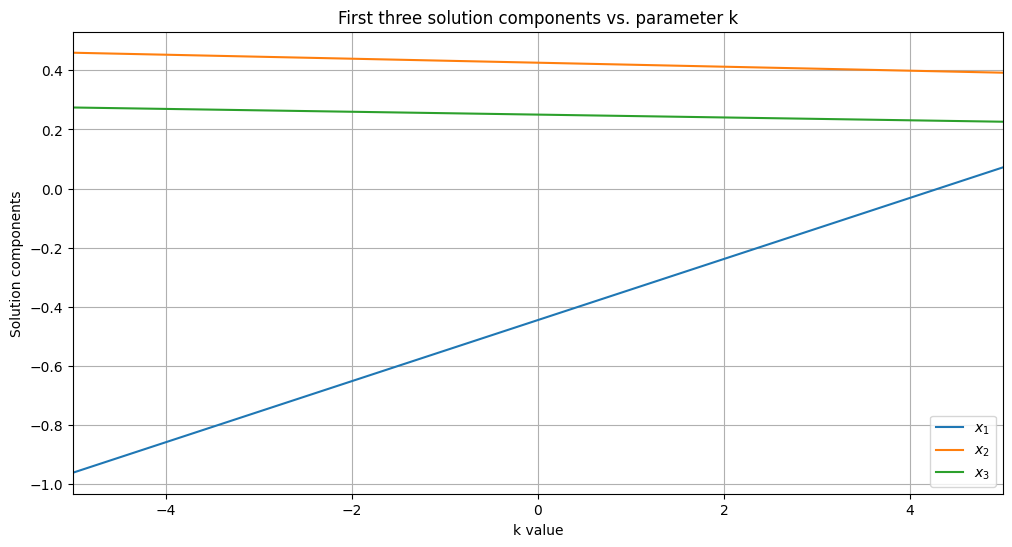

In [75]:
plt.figure(figsize=(12, 6))

# Plot the first three solution components
for i in range(3):
    plt.plot(k, xk_LU[:, i], label=f'$x_{i+1}$')

plt.grid(True)
plt.xlabel('k value')
plt.ylabel('Solution components')
plt.title('First three solution components vs. parameter k')
plt.legend()
plt.xlim(-5, 5)
plt.show()

## Discussion

### Computational Efficiency

The results clearly demonstrate the efficiency of using LU factorization when solving multiple linear systems with the same coefficient matrix but different right-hand sides. Here's why:

1. **Naive Gaussian Elimination (Method 1)**: For each new right-hand side, we perform the full O(n³) elimination process. With a 10×10 matrix, this becomes quite expensive, especially in Python.

2. **LU Factorization (Method 2)**: We perform LU factorization once (an O(n³) operation), but for each new right-hand side, we only need to perform forward and backward substitution (each an O(n²) operation). This gives us a theoretical speedup of O(n) for many right-hand sides.

3. **NumPy's linalg.solve (Method 3)**: While it uses optimized LAPACK routines under the hood (which use LU decomposition), it recalculates the decomposition for each right-hand side. Its speed comes from being implemented in highly-optimized compiled code.

For solving multiple systems with the same coefficient matrix, explicitly factoring the matrix once and reusing it (Method 2) is theoretically and practically more efficient. The advantage becomes more pronounced with larger matrices and more systems to solve, as we've seen with the 10×10 example.

### Math Behind LU Factorization

LU factorization decomposes a matrix A into a product of a lower triangular matrix L and an upper triangular matrix U:

$$A = LU$$

When partial pivoting is used (which is typical for numerical stability), we have:

$$PA = LU$$

where P is a permutation matrix.

To solve the system $Ax = b$, we:

1. Compute the LU factorization $PA = LU$
2. Solve $Ly = Pb$ using forward substitution
3. Solve $Ux = y$ using backward substitution

### Applications

This technique is valuable in many engineering applications, such as:

- Finite element analysis with multiple load cases
- Circuit analysis with multiple sources
- Parameter sensitivity studies (as demonstrated in this worksheet)
- Control system analysis with varying inputs
- Implicit time integration schemes
- Monte Carlo simulations

### Implementation in Scientific Computing

In real scientific computing applications, libraries like SciPy provide specialized functions like `lu_factor` and `lu_solve` precisely because reusing matrix factorizations is so important for performance. Always look for these opportunities in your numerical code!